# Smart Bin Model

## Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from PIL import Image
import io
import json
import pathlib

In [4]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2

In [5]:
print(tf.__version__)

2.10.0


In [6]:
tf.config.set_visible_devices([], 'GPU')

In [7]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Path Preparation

### Create Path

In [10]:
main_dir = 'Dataset'

In [11]:
if os.path.exists(main_dir):
    for subdir_name in os.listdir(main_dir):
        subdir_path = os.path.join(main_dir, subdir_name)

        if os.path.isdir(subdir_path):
            print(f'Memproses subdir: {subdir_path}')           

Memproses subdir: Dataset\Can
Memproses subdir: Dataset\Plastic Bottle
Memproses subdir: Dataset\UBC


In [12]:
data_paths = []
labels = []

class_list = os.listdir(main_dir)

for classes in class_list:
    class_path = os.path.join(main_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for file in file_list:
            f_path = os.path.join(class_path, file)
            data_paths.append(f_path)
            labels.append(classes)

In [13]:
# Path Checking

F_series = pd.Series(data_paths, name='file_paths')
L_series = pd.Series(labels, name='labels')

data_df = pd.concat([F_series, L_series], axis=1)

print(data_df.head())
print(data_df['labels'].value_counts())

                                          file_paths labels
0  Dataset\Can\-2-_jpeg.rf.43dc833156af33fd174c94...    Can
1  Dataset\Can\-3-_jpeg.rf.8cacea1374fba60c6f5ed2...    Can
2  Dataset\Can\-_jpeg.rf.5cb94a5cad118144c78be418...    Can
3  Dataset\Can\1000_F_342875993_cFbHaeM6BvYEbNMu2...    Can
4  Dataset\Can\1000_F_484674280_e2mhjTx7lqxK3FlJ9...    Can
labels
UBC               3620
Plastic Bottle    3461
Can               3450
Name: count, dtype: int64


## Data Split

In [7]:
train_size = 0.8 
test_size = 0.2

In [14]:
train_set, test_set = train_test_split(data_df, test_size=test_size, shuffle=True, stratify=data_df['labels'], random_state=42)

print('train_set length:', len(train_set), 'test_set length:', len(test_set))


train_set length: 8424 test_set length: 2107


## Preprocessing

### Standarisasi

In [15]:
# Standarisasi Data
height = 224
width = 224
channels = 3
batch_size = 512
img_shape = (height, width, channels)
img_size = (height, width)

### Augmentation

In [16]:
train_datagen = ImageDataGenerator(
    rescale= 1.0/255.0,
    rotation_range= 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode= 'nearest'
)

In [17]:
# Train Data
train_gen = train_datagen.flow_from_dataframe(train_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 8424 validated image filenames belonging to 3 classes.


In [18]:
test_datagen = ImageDataGenerator(
    rescale= 1./255.
)

In [19]:
# Test Data
test_gen = test_datagen.flow_from_dataframe(test_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 2107 validated image filenames belonging to 3 classes.


In [20]:
train_categories = list(train_gen.class_indices.keys())
print(train_categories)

['Can', 'Plastic Bottle', 'UBC']


## Data Checking

### Show Images

In [21]:
from PIL import UnidentifiedImageError

def open_image(image_path):
    try:
        with Image.open(image_path) as img:
            pass
    except UnidentifiedImageError:
        print(f"File {image_path} tidak dikenali atau rusak. Menghapus file.")
        os.remove(image_path)
    except Exception as e:
        print(f"Terjadi kesalahan saat membuka {image_path}: {e}")

def process_images_in_folder(root_folder):
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):  # Tambahkan format gambar yang diperlukan
                open_image(file_path)

root_folder_path = 'Dataset'
process_images_in_folder(root_folder_path)

In [22]:
def show_samples(generator):
    images, labels = next(generator)
    plt.figure(figsize= (20, 20))
    for i in range(min(len(labels), 20)):
        plt.subplot(5, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = train_categories[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [23]:
print(data_df['labels'].value_counts())

labels
UBC               3620
Plastic Bottle    3461
Can               3450
Name: count, dtype: int64


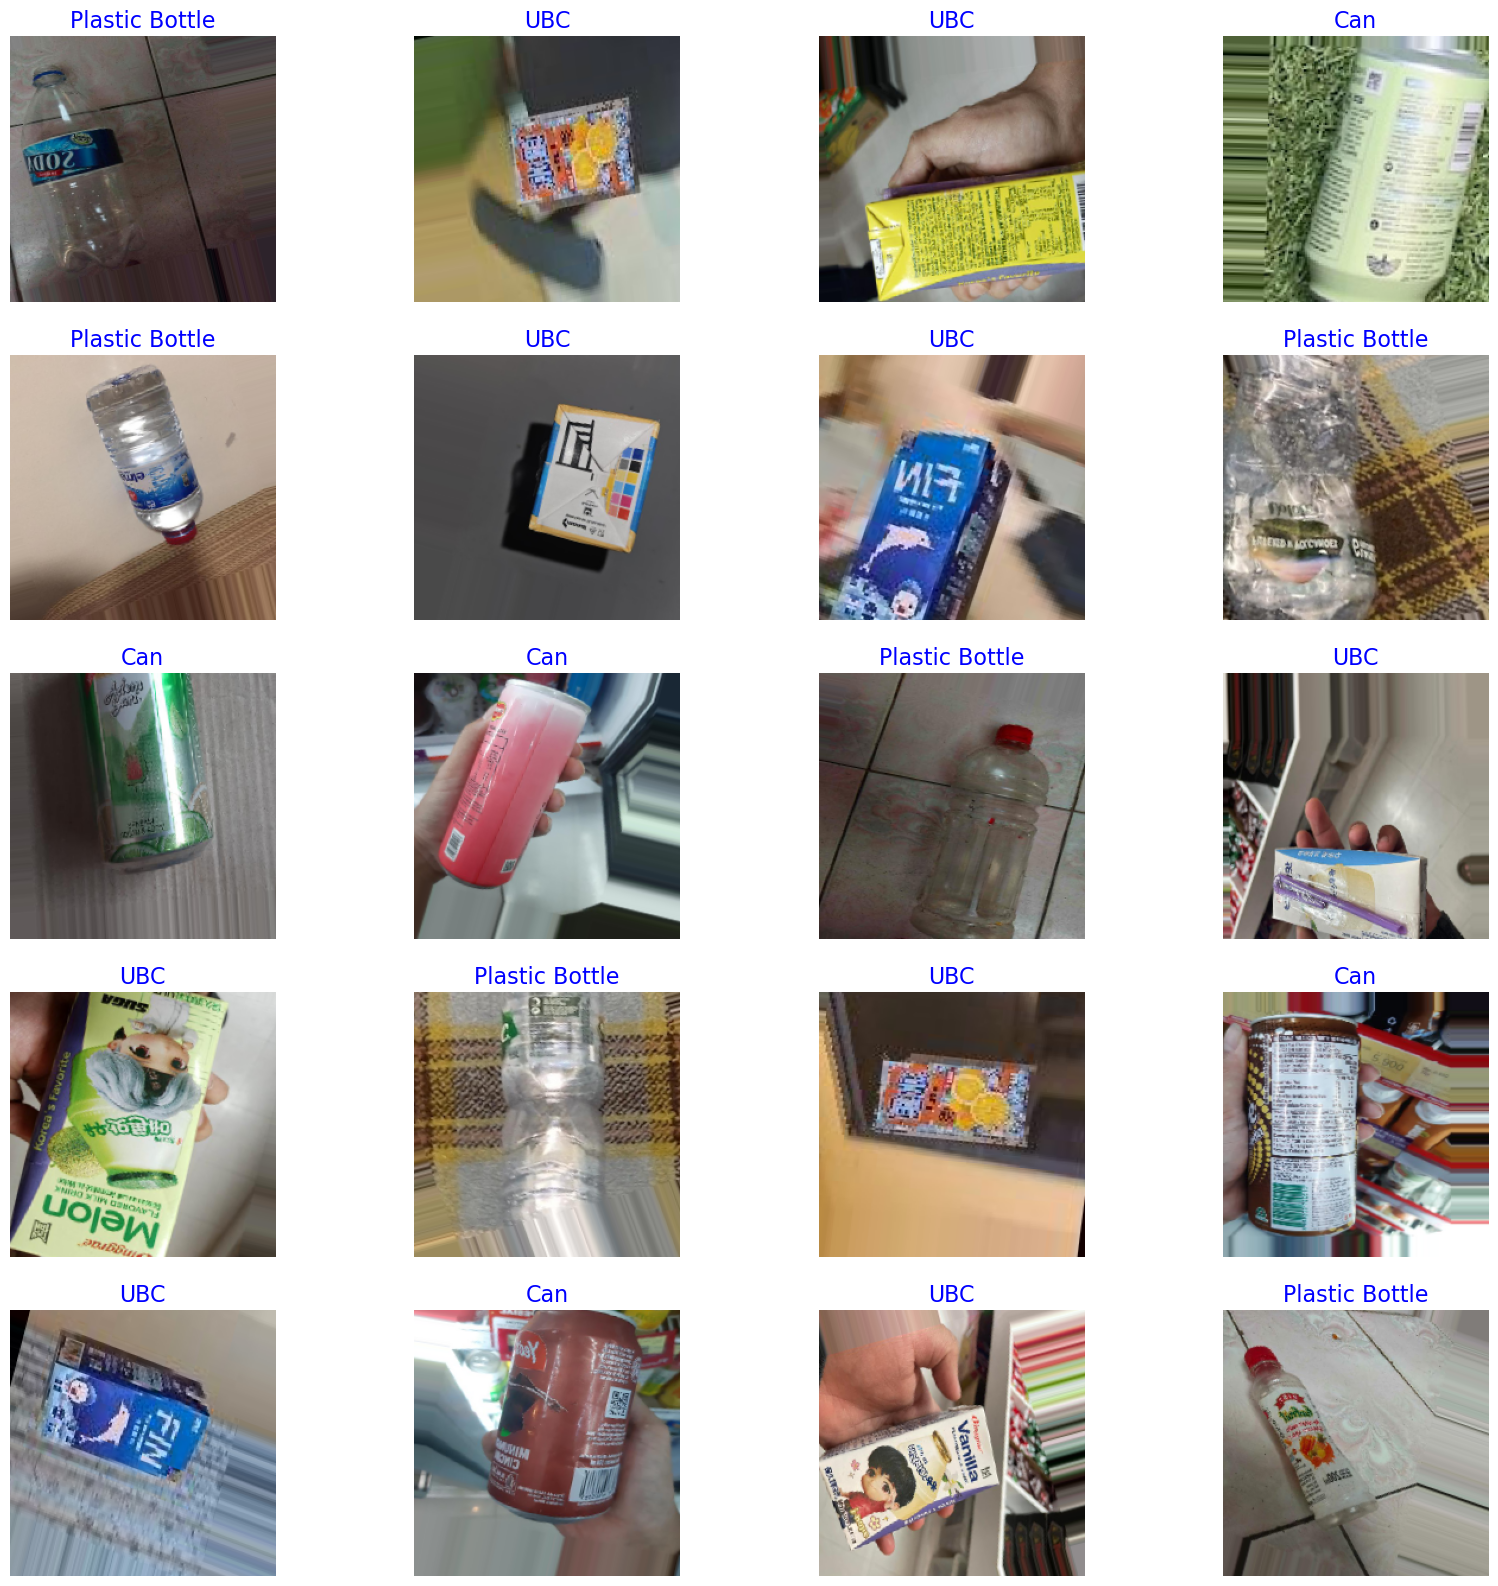

In [24]:
show_samples(train_gen)

## Model

### Design

In [25]:
num_classes = len(classes)

base_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_shape=img_shape)
for layer in base_model.layers:
    layer.trainable = False

extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block_15_project_BN').output)

In [26]:
extractor_output_shape = extractor.output_shape
print("Extractor output shape:", extractor_output_shape)

Extractor output shape: (None, 7, 7, 160)


In [27]:
model = Sequential([
    extractor,
    Conv2D(160, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(80, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Build the model
model.build((None, *img_shape))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 160)         1364864   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 160)         230560    
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 160)        640       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 160)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 80)          115280    
                                                                 
 batch_normalization_1 (Batc  (None, 3, 3, 80)         3

### Training

In [28]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [29]:
history = model.fit(train_gen, 
                    epochs=30, 
                    validation_data=test_gen,
                    steps_per_epoch=len(train_set) // batch_size,
                    validation_steps=len(test_set) // batch_size, 
                    callbacks=[early_stopping]
)

Epoch 1/30
 2/16 [==>...........................] - ETA: 19:30 - loss: 4.1187 - accuracy: 0.3584

KeyboardInterrupt: 

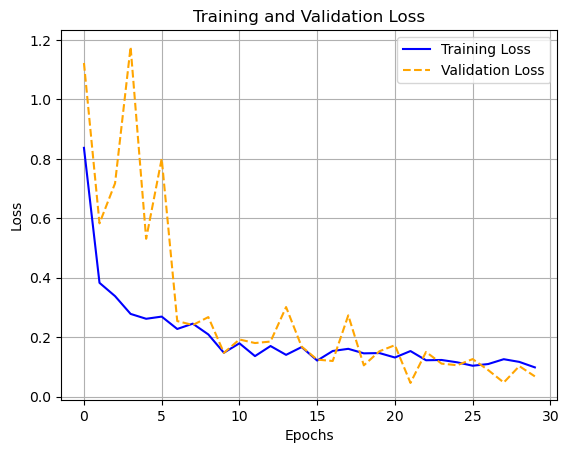

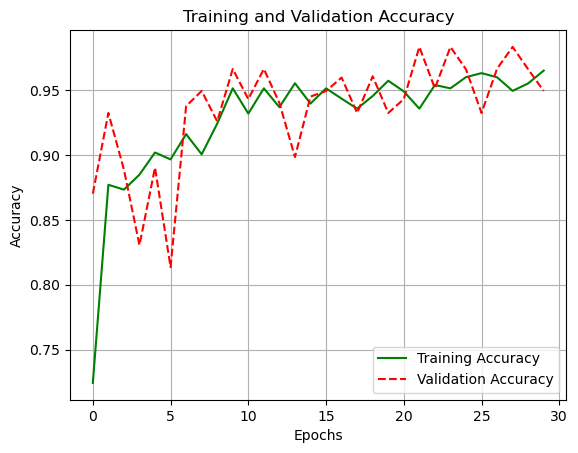

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Convert Model

### TF-Lite

In [110]:
model.save('model.keras')

Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x000001D341CA8AF0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x000001D341CA8AF0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x000001D341CA8AF0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x000001D341CA8280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert

Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x000001D341CA8280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x000001D341CA8280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x000001D32B1411B0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert

Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x000001D32B1411B0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function TFLayer._default_save_signature.<locals>.serving_default at 0x000001D32B1411B0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [111]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

: 

In [ ]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

### TFJS

In [93]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

### TF-Serving

In [ ]:
save_tf_serving = os.path.join('TF-Serving')
tf.saved_model.save(best_model, save_tf_serving)

## Inference

## Req.txt

In [17]:
!pip freeze > requirements.txt